In [1]:
import ggml_ot

import requests
import anndata as ad
import os
import numpy as np
from torch.utils.data import DataLoader

/home/kuebra/.cache/pypoetry/virtualenvs/ggml-ot-qpshuKxx-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# URL of the dataset
url = "https://datasets.cellxgene.cziscience.com/c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
destination_path = "data/czi_dataset.h5ad"

# create the directory if it doesn't exist
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# download and save the file
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(destination_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"Dataset downloaded and saved to: {destination_path}")

Dataset downloaded and saved to: data/czi_dataset.h5ad


In [ ]:
# load anndata object into memory
adata = ad.read_h5ad(destination_path)

In [5]:
# load the dataset in "backed" mode. This way, not the whole dataset will be loaded into memory
# which can be useful for large datasets or little RAM.
# Note that in backed mode, only adata.X can be modified.
adata = ad.read_h5ad("data/czi_dataset.h5ad", backed='r')

# subsample dataset to 10,000 cells
n_cells = adata.n_obs
sample_size = 10000 # adjust as needed
if sample_size > n_cells:
    raise ValueError("Sample size is larger than total number of cells!")
idx = np.random.choice(n_cells, size=sample_size, replace=False)

# load only the subset into memory
adata_subset = adata[idx, :].to_memory()

# save the subsampled dataset for later use
adata_subset.write("data/subset_10000.h5ad")


In [2]:
# patient or donor id
patient_col = "sample"

# class or disease labels
label_col = "patient_group"

# number of cells to sample from each patient
n_cells = 50

# number of features to retain (PCA is used for dimensionality reduction)
pca_comps = 20

# filter out low-variance genes from dataset
filter_highvar_genes = True

# ratio of patients to subsample from the dataset
subsample_patient_ratio = 1

local_path = "data/subset_10000.h5ad"


In [3]:
training_data = ggml_ot.scRNA_Dataset(local_path,patient_col=patient_col,label_col=label_col,subsample_patient_ratio=subsample_patient_ratio,n_cells=n_cells,n_feats=pca_comps,filter_genes=filter_highvar_genes)

View of AnnData object with n_obs × n_vars = 10000 × 7786
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'dissociation_score', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'final_cluster', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'X_approximate_distribution', 'batch_condition', 'cell_type_original_colors', 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_harmony', 'X_pca', 'X_umap'


In [4]:
train_dataset = DataLoader(training_data, batch_size=128, shuffle=True)

In [5]:
# define parameters
alpha = 10
lambda_ = 0.1

neighbor_t = 5
rank_k = 5 

lr = 0.02
norm = 1


Running GGML with alpha: 10, lambda: 0.1, rank: 5


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Iteration 1 with Loss  31.946552276611328


100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


Iteration 2 with Loss  13.051522254943848


100%|██████████| 11/11 [00:12<00:00,  1.15s/it]


Iteration 3 with Loss  8.423694610595703


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Iteration 4 with Loss  6.673758029937744


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Iteration 5 with Loss  5.691928386688232


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Iteration 6 with Loss  5.074220657348633


100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Iteration 7 with Loss  4.767143726348877


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Iteration 8 with Loss  4.52532958984375


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Iteration 9 with Loss  4.356339931488037


100%|██████████| 11/11 [00:12<00:00,  1.09s/it]


Iteration 10 with Loss  4.174615383148193
Compute all OT distances after 10 iterations


100%|██████████| 28/28 [00:01<00:00, 22.14it/s]


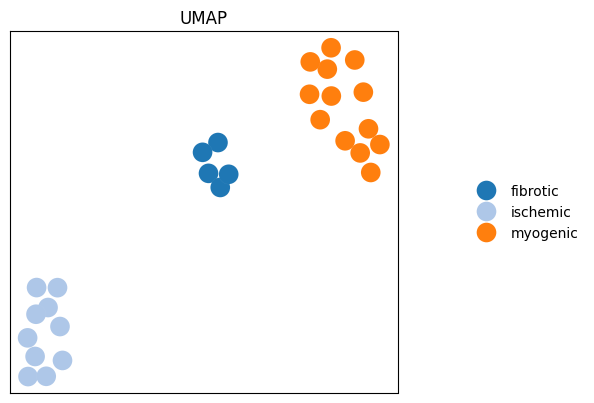

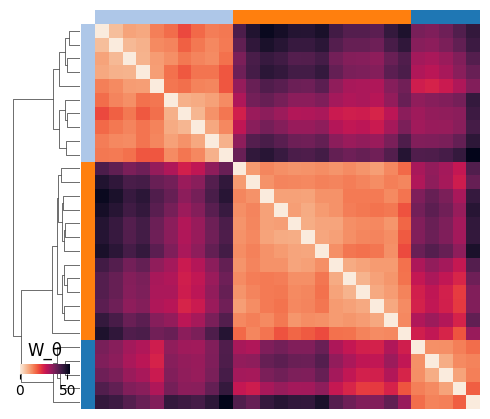

In [6]:
w_theta = ggml_ot.ggml(train_dataset,a=alpha,l=lambda_,k=rank_k,lr=lr,norm=norm,max_iterations=10,plot_i_iterations=10,dataset=training_data,n_threads=64)

For more detailed examples on plotting, see "synth_Test.ipynb"

PCA
(28, 50, 20)


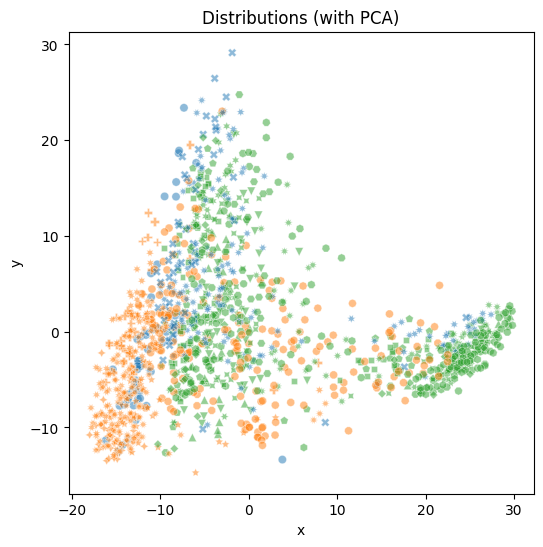

In [7]:
import matplotlib.pyplot as plt
# plot distributions using PCA
a = training_data.distributions
b = training_data.distributions_labels
ggml_ot.plot_distribution(a, b, title = "Distributions (with PCA)", legend = False)
plt.show()

Text(0.5, 1.0, 'Euclidean and Mahalanobis')

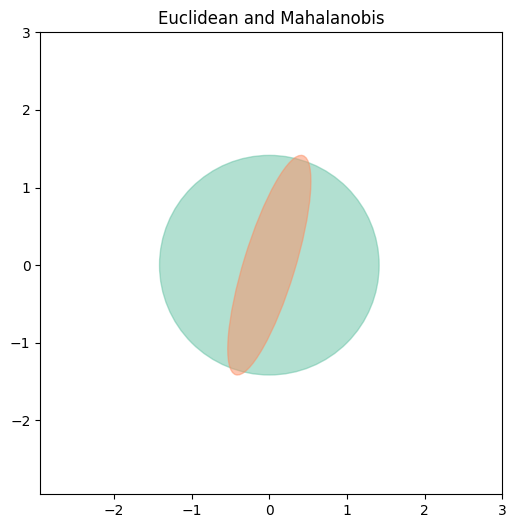

In [8]:
m = np.transpose(w_theta) @ w_theta  # Mahalanobis matrix

fig, axs = plt.subplots(figsize=(12, 6))

ax = ggml_ot.plot_ellipses([np.identity(2), m[:2, :2]], ax=axs)
ax.set_title(r'Euclidean and Mahalanobis')

100%|██████████| 28/28 [00:01<00:00, 15.34it/s]


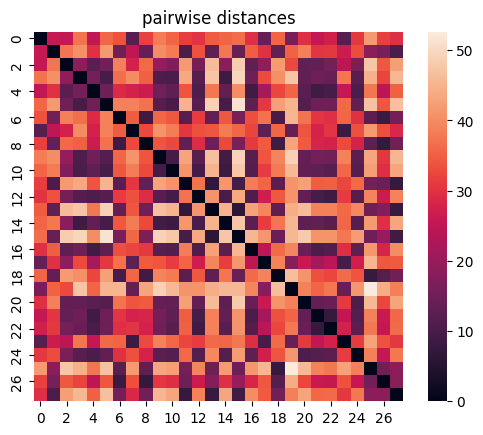

In [13]:
D_ggml = training_data.compute_OT_on_dists(w = w_theta, plot = False)
ggml_ot.plot_heatmap(D_ggml)

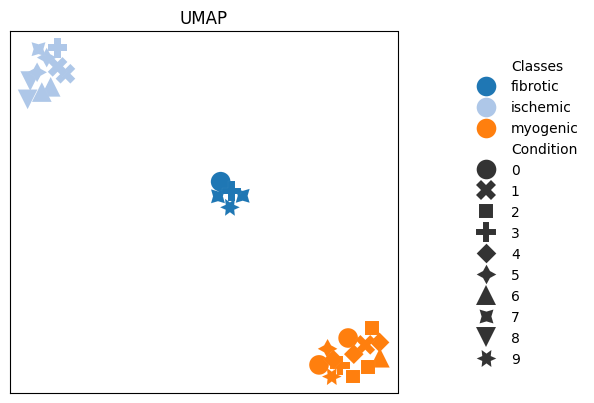

In [10]:
symbols = [i % 10 for i in range(len(training_data.distributions))]
colors = training_data.distributions_labels

emb = ggml_ot.plot_emb(D_ggml,method='umap',colors=training_data.disease_labels,symbols=symbols,legend="Side",title="UMAP",verbose=True,s=200)

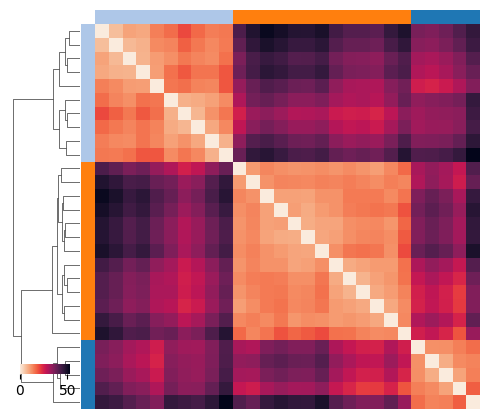

In [11]:
linkage = ggml_ot.plot_clustermap(D_ggml, training_data.distributions_labels)